# Load data

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

df  = pd.read_csv('TrainingSet.csv', index_col=0)

# Explotoray Data Analysis

In [121]:
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [122]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

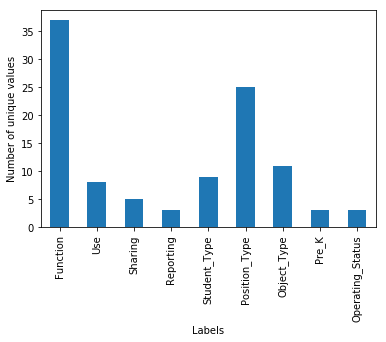

In [124]:
# count unique labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique)
num_unique_labels.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.show()

# Predefined Functions

In [125]:
# a function that will make sure that each label appear in each split
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])


# Define combine_text_columns(): Convert the text data in each row of the DataFrame into a single string.
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

# Resample data

* Resample 80,000 rows from 400277 rows in the original dataset.  
* Create dummy variables for our labels
* split our sampled dataset into a training set and a test set

In [126]:
# Get labels and convert to dummy variables: label_dummies
LABELS = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

#dummy_labels = pd.get_dummies(df[LABELS])

SAMPLE_SIZE = 80000

sampling = multilabel_sample_dataframe(df, 
                                       pd.get_dummies(df[LABELS]), 
                                       size=SAMPLE_SIZE, 
                                       min_count=25, 
                                       seed=43)

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[NON_LABELS],
                                                               pd.get_dummies(sampling[LABELS]), 
                                                               size=0.2,
                                                               min_count=3,
                                                               seed=43)

# Process the numeric features

In [131]:
NUMERIC_COLUMNS = list(sampling.describe().columns)
numeric_data_only = sampling[NUMERIC_COLUMNS].fillna(-1000)
print(NUMERIC_COLUMNS)

['FTE', 'Total']


In [134]:
# Create training and test sets
X_train1, X_test1, y_train1, y_test1 = multilabel_train_test_split(numeric_data_only,
                                                                   pd.get_dummies(sampling[LABELS]),
                                                                   size=0.2,
                                                                   seed=123, 
                                                                   min_count=3)

In [ ]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train1, y_train1)

In [144]:
# Print the accuracy
accuracy1 = clf.score(X_test1, y_test1)
print("Accuracy: {}".format(accuracy1))

Accuracy: 0.000125


# Process the text features using  Bag of words

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Create the text vector
text_vector = combine_text_columns(sampling)

# Split using ALL data in sample_df
X_train2, X_test2, y_train2, y_test2 = multilabel_train_test_split(text_vector,
                                                                   pd.get_dummies(sampling[LABELS]),
                                                                   size=0.2,
                                                                   seed=22,
                                                                   min_count=3)
pl2 = Pipeline([('vec', CountVectorizer()),
               ('clf', OneVsRestClassifier(LogisticRegression()))
              ])

# Fit pl to the training data
pl2.fit(X_train2, y_train2)

{'Total', 'Reporting', 'Object_Type', 'Sharing', 'Function', 'Pre_K', 'Operating_Status', 'Student_Type', 'Use', 'Position_Type', 'FTE'}


/home/sergio212/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_interc

In [156]:
# Compute and print accuracy
accuracy2 = pl2.score(X_test2, y_test2)
print(accuracy2)

0.8090625


# Train model pipeline

For text data, `combine_text_columns` is used to select and properly format text data for tokenization by `CountVectorizer`.

For numeric features, use lambda function to select the subset of the dataset.

But before instantiating a multiple-datatype pipeline,  we use `FunctionTransformer` to turn a Python function into an object that a scikit-learn pipeline can understand. `validate=False` means not to check NaNs or validate the dtypes of the input.

In [139]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction.text import CountVectorizer

# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

The preprocessing step uses `FeatureUnion` to join the results of nested pipelines that each rely on `FunctionTransformer` to select multiple datatypes and do the preprocessing such as `Imputer` and `CountVectorizer`. 

In [141]:
# Define the token pattern that contains only alphanumeric characters.
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer
vec = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                      ngram_range=(1,2))

numeric_pipline = Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])
text_pipline = Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', vec)
                ])

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', numeric_pipline),
                ('text_features', text_pipline)
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)


/home/sergio212/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


{'Total', 'FTE'}


/home/sergio212/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sergio212/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'Total', 'FTE'}


In [153]:
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print(accuracy)

{'Total', 'FTE'}
0.449125


# Predict holdout set and write submission

* Use trained pipeline to predict the holdout dataset
* write our predictions to a file 'predictions.csv' that we can submit on [DrivenData](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/submissions/)

In [190]:
# Load holdout data
holdout = pd.read_csv('TestSet.csv', index_col=0)


print(sampling[NON_LABELS].info())
print(holdout.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 38 to 361417
Data columns (total 16 columns):
Object_Description        75008 non-null object
Text_2                    17761 non-null object
SubFund_Description       61110 non-null object
Job_Title_Description     58378 non-null object
Text_3                    21691 non-null object
Text_4                    10685 non-null object
Sub_Object_Description    18291 non-null object
Location_Description      32642 non-null object
FTE                       25089 non-null float64
Function_Description      68388 non-null object
Facility_or_Department    10703 non-null object
Position_Extra            52623 non-null object
Total                     79085 non-null float64
Program_Description       60695 non-null object
Fund_Description          40586 non-null object
Text_1                    58275 non-null object
dtypes: float64(2), object(14)
memory usage: 10.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50064 entr

In [193]:
# Make predictions
predictions = pl.predict_proba(holdout)

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns,
                             index=holdout.index,
                             data=predictions)

prediction_df = prediction_df.reindex(sorted(prediction_df.columns), axis=1)

# Save prediction_df to csv
prediction_df.to_csv('predictions.csv')

# Submit the predictions for scoring: score
#score = score_submission('predictions.csv')

# Print score
#print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

{'Total', 'FTE'}


In [194]:
import drivendata_validator.drivendata_validator
# no parameters unless we have a read_csv kwargs file
v = drivendata_validator.drivendata_validator.DrivenDataValidator()

v.validate('SubmissionFormat.csv', 'predictions.csv')

,Function__Aides Compensation,Function__Career & Academic Counseling,Function__Communications,Function__Curriculum Development,Function__Data Processing & Information Services,Function__Development & Fundraising,Function__Enrichment,Function__Extended Time & Tutoring,Function__Facilities & Maintenance,Function__Facilities Planning,...,Student_Type__Special Education,Student_Type__Unspecified,Use__Business Services,Use__ISPD,Use__Instruction,Use__Leadership,Use__NO_LABEL,Use__O&M,Use__Pupil Services & Enrichment,Use__Untracked Budget Set-Aside
180042,0.028882,0.006120,2.736890e-05,0.004332,0.002931,1.190150e-04,0.009632,0.006778,0.014876,8.089289e-05,...,0.077189,0.449256,0.002307,0.037888,0.187609,0.010848,0.173872,0.045784,0.057658,0.001401
28872,0.020710,0.004764,3.663710e-05,0.005272,0.004591,1.041503e-04,0.295022,0.006257,0.024145,7.009247e-05,...,0.075289,0.741129,0.006889,0.012943,0.024307,0.036649,0.080674,0.068500,0.155857,0.000154
186915,0.084625,0.001882,9.177054e-06,0.003309,0.000978,1.758403e-05,0.006704,0.001346,0.008631,3.279915e-05,...,0.066082,0.353271,0.001228,0.022863,0.713346,0.010644,0.084012,0.022952,0.035810,0.000024
412396,0.084426,0.001884,9.172730e-06,0.003308,0.000978,1.758683e-05,0.006703,0.001347,0.008624,3.276205e-05,...,0.066075,0.353828,0.001224,0.022829,0.730517,0.010629,0.083978,0.022963,0.035805,0.000024
427740,0.022808,0.010693,7.552324e-06,0.001729,0.002501,1.423556e-05,0.004289,0.000195,0.016713,2.789985e-05,...,0.038935,0.973724,0.009786,0.051096,0.009474,0.477004,0.046823,0.061799,0.047076,0.000068
69847,0.005121,0.002639,1.347978e-06,0.003654,0.000661,2.135715e-05,0.003293,0.001459,0.011462,5.761611e-06,...,0.027491,0.266324,0.001494,0.086587,0.055805,0.179279,0.099606,0.023810,0.032611,0.000278
358824,0.036824,0.003718,2.854050e-05,0.004847,0.001112,1.116971e-04,0.012034,0.001760,0.007564,8.377875e-05,...,0.787734,0.066232,0.000418,0.026195,0.022700,0.002569,0.079417,0.168814,0.098596,0.000089
254148,0.041936,0.031042,6.577200e-05,0.004679,0.000308,2.248063e-04,0.008794,0.001647,0.007553,1.168632e-05,...,0.791329,0.001189,0.000289,0.038886,0.004775,0.010023,0.311561,0.058172,0.292341,0.000033
296,0.025679,0.001511,9.486644e-06,0.002926,0.001806,6.820660e-05,0.006606,0.002172,0.015977,3.111575e-05,...,0.029884,0.641817,0.003901,0.017210,0.720969,0.011224,0.119263,0.029173,0.035204,0.000670
416755,0.021634,0.005095,1.479098e-04,0.006045,0.002273,1.263743e-04,0.010231,0.000497,0.022488,1.177621e-04,...,0.026092,0.875566,0.005275,0.018625,0.004930,0.022189,0.125866,0.484711,0.066810,0.000252
